In [1]:
import warnings
warnings.simplefilter('ignore')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge, ARDRegression, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('../datasets/processed_dataset.csv')
df.head()

,Course Code,Course Title,Student Number,Department Code,Course Level,Letter Grade,Status,GPA,Standing,Completed Credits,Completed ECTS,GPA Student - Subject,Avg. Grade - Taken,Avg. Grade - Students_Subject,Semester,Theoritical,Practical,Course Credit,ECTS,Course Year
0,MGT 511,Küresel Yönetim Düşüncesi,1182,MBA/NT,Graduate,A-,Successful,3.54,Freshman,15,25,3.540000,3.576471,3.324211,2011 - Fall,3,0,3,5,5
1,UNI 123,Textual Analysis and Effective Communication,134,EE,Undergraduate,C-,Successful,3.67,Freshman,18,30,3.666667,2.120833,2.703226,2011 - Fall,3,0,3,5,1
2,UNI 115,Turkish for International Students I,217,CTV,Undergraduate,A-,Successful,3.70,Freshman,3,5,3.700000,3.900000,2.703226,2011 - Fall,3,0,3,5,1
3,MGT 511,Küresel Yönetim Düşüncesi,1227,MBA/NT,Graduate,B,Successful,3.00,Freshman,15,25,3.000000,3.576471,3.324211,2011 - Fall,3,0,3,5,5
4,MGT 541,Uluslararası Pazarlama,1225,MBA/NT,Graduate,B+,Successful,3.33,Freshman,9,15,3.333333,3.238095,3.324211,2011 - Fall,3,0,3,5,5


In [3]:
df.drop([df.columns[0], df.columns[1], df.columns[2]], inplace=True, axis=1)   # dropping course details

In [4]:
df = pd.concat([df, pd.get_dummies(df['Course Year'], prefix='Course Year'), pd.get_dummies(df['Department Code'], prefix='Department Code'), pd.get_dummies(df['Course Level'], prefix='Course Level'), pd.get_dummies(df['Standing'], prefix='Standing'), pd.get_dummies(df['Status'], prefix='Status')], axis=1)
df.drop(['Course Year', 'Department Code', 'Course Level', 'Status', 'Standing'], axis=1, inplace=True)

In [5]:
columns = df.columns

In [6]:
le = LabelEncoder()
le.fit(['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F'])

LabelEncoder()

In [7]:
def get_train_data(df, train_sem, columns):
    dataFrame = pd.DataFrame(columns=columns)
    for sem in train_sem:
        dataFrame = pd.concat([dataFrame, df[df.iloc[:, 7] == sem]], ignore_index=True)
    for idx in dataFrame.index:
        semester = dataFrame.iloc[idx, 7]
        dataFrame.iloc[idx, 7] = semester.split()[2].strip()
    
    X_train = dataFrame.drop('Semester', axis=1)
    y_train = le.transform(X_train.pop('Letter Grade'))
    return X_train, y_train

In [8]:
def normalize(X_train, X_test):
    X_train_cols = X_train.columns
    X_test_cols = X_test.columns
    sc = StandardScaler()
    obj = sc.fit(X_train)
    return pd.DataFrame(obj.transform(X_train), columns=X_train_cols), pd.DataFrame(obj.transform(X_test), columns=X_test_cols)

In [9]:
def get_clusters(n_clusters, X, y):
    kmeans_dict = {}
    kmeans = KMeans(n_clusters=n_clusters).fit(X[['GPA', 'Completed Credits'] + list(X.columns[16:51])])
    for label_idx in range(len(kmeans.labels_)):
        kmeans_dict.setdefault(kmeans.labels_[label_idx], {})
        kmeans_dict[kmeans.labels_[label_idx]].setdefault('X', pd.DataFrame(columns=X.columns))
        kmeans_dict[kmeans.labels_[label_idx]].setdefault('y', [])
        
        df_row = list(X.iloc[label_idx, :])
        kmeans_dict[kmeans.labels_[label_idx]]['X'].loc[len(kmeans_dict[kmeans.labels_[label_idx]]['X'])] = df_row
        kmeans_dict[kmeans.labels_[label_idx]]['y'].append(y[label_idx])
    return kmeans_dict    

In [10]:
def get_error_score(df, columns, model):
    error_scores = {}
    sorted_semesters = sorted(set(df.iloc[:, 7]))
    for num_clusters in range(2, 8):
        for sem_idx in range(1, len(sorted_semesters)):
            training_sem = sorted_semesters[:sem_idx]
            test_sem = sorted_semesters[sem_idx]
            X_train, y_train = get_train_data(df, training_sem, columns)

            X_test = df[df.iloc[:, 7] == test_sem]
            X_test.drop('Semester', axis=1, inplace=True)
            X_test.index = range(len(X_test))
            y_test = le.transform(X_test.pop('Letter Grade'))

            X_train, X_test = normalize(X_train, X_test)

            clusters_train = get_clusters(num_clusters, X_train, y_train)
            clusters_test = get_clusters(num_clusters, X_test, y_test)
            
            for cluster_label in clusters_train:
                model.fit(clusters_train[cluster_label]['X'], clusters_train[cluster_label]['y'])
                
                y_pred_test = model.predict(clusters_test[cluster_label]['X'])
                rmse_test = np.sqrt(mean_squared_error(clusters_test[cluster_label]['y'], y_pred_test))
                r2_test = r2_score(clusters_test[cluster_label]['y'], y_pred_test)
                
                y_pred_train = model.predict(clusters_train[cluster_label]['X'])
                rmse_train = np.sqrt(mean_squared_error(clusters_train[cluster_label]['y'], y_pred_train))
                r2_train = r2_score(clusters_train[cluster_label]['y'], y_pred_train)
                
                error_scores.setdefault(str(num_clusters), {})
                error_scores[str(num_clusters)].setdefault(str(sem_idx), {})
                error_scores[str(num_clusters)][str(sem_idx)].setdefault(str(cluster_label), {})
                error_scores[str(num_clusters)][str(sem_idx)][str(cluster_label)]['train'] = [rmse_train, r2_train]
                error_scores[str(num_clusters)][str(sem_idx)][str(cluster_label)]['test'] = [rmse_test, r2_test]
    return error_scores

In [11]:
def plot_error_scores(scores, title):
    best_scores = {}
    for n_clusters in scores:
        best_scores.setdefault(n_clusters, [0, 0, 0, 0])   # [rmse_train, rmse_test, r2_train, r2_test]
        for n_training_sem in scores[n_clusters]:
            clust_scores = scores[n_clusters][n_training_sem].values()
            for s in clust_scores:
                if s['train'][0] > best_scores[n_clusters][0]:
                    best_scores[n_clusters][0] = s['train'][0]
                elif s['train'][1] > best_scores[n_clusters][2]:
                    best_scores[n_clusters][2] = s['train'][1]
                elif s['test'][0] > best_scores[n_clusters][1]:
                    best_scores[n_clusters][1] = s['test'][0]
                elif s['test'][1] > best_scores[n_clusters][3]:
                    best_scores[n_clusters][3] = s['test'][1]
        
    fig, ax = plt.subplots(figsize=(15,5))
    x = np.arange(2,8)
    ax.plot(x, [best_scores[k][0] for k in sorted(best_scores)], marker='o', label='RMSE train', linestyle='--', linewidth=3, mew=3)
    ax.plot(x, [best_scores[k][1] for k in sorted(best_scores)], marker='x', label='RMSE test', linestyle='-', linewidth=3, mew=3)
    ax.plot(x, [best_scores[k][2] for k in sorted(best_scores)], marker='v', label='R\u00b2 train', linestyle='dotted', linewidth=3, mew=3)
    ax.plot(x, [best_scores[k][3] for k in sorted(best_scores)], marker='d', label='R\u00b2 test', linestyle='dashdot', linewidth=3, mew=3)
    
    ax.set_title(title, fontfamily='serif', fontsize=20)
    ax.set_yticklabels(ax.get_yticks(), fontfamily='serif', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(['k={}'.format(i) for i in range(2, 8)], fontfamily='serif', fontsize=20)
    ax.set_xlabel('Number of Clusters (k)', fontsize=20, fontfamily='serif')
    ax.set_ylabel('Error', fontsize=20, fontfamily='serif')
    ax.grid(True)
    ax.legend(prop={'size': 20, 'family': 'serif'}, loc='center', bbox_to_anchor=(0.5, -0.25), ncol=4)
    
#     plt.savefig('sample.svg', bbox='tight')

In [ ]:
model_errors = {}

In [12]:
import os
results = {}
files = os.listdir('../results/clustering__baseline')
for f in files:
    with open('../results/clustering__baseline/'+f) as fr:
        data = json.load(fr)
        for k in data:
            results[f.split('.')[0]] = data[k]

In [ ]:
errors = get_error_score(df, columns, DecisionTreeRegressor())
model_errors['DecisionTreeRegressor'] = errors

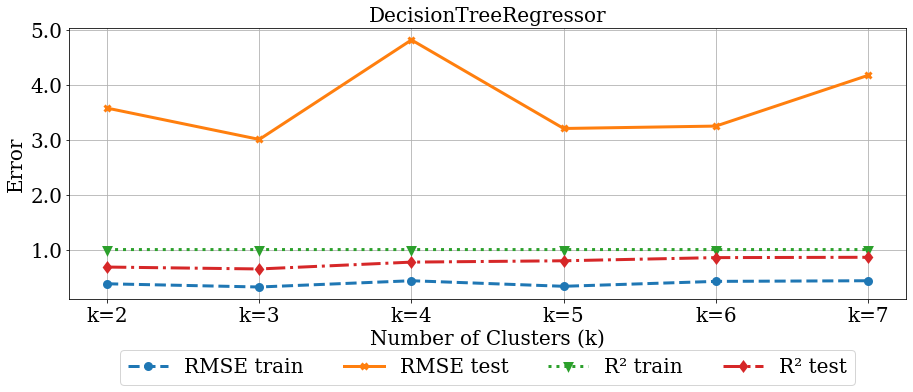

In [13]:
plot_error_scores(results['cluster_results_dt'], 'DecisionTreeRegressor')

In [ ]:
errors = get_error_score(df, columns, KNeighborsRegressor())
model_errors['KNeighborsRegressor'] = errors

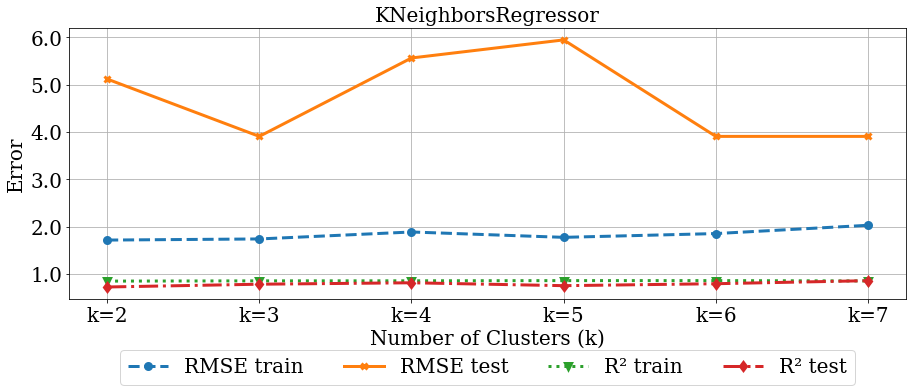

In [14]:
plot_error_scores(results['cluster_results_knn'], 'KNeighborsRegressor')

In [ ]:
errors = get_error_score(df, columns, SVR())
model_errors['SVR'] = errors

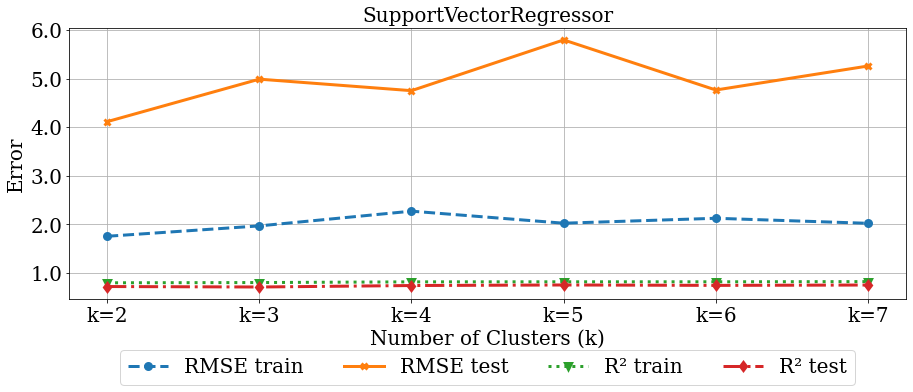

In [15]:
plot_error_scores(results['cluster_results_svr'], 'SupportVectorRegressor')

In [ ]:
errors = get_error_score(df, columns, BayesianRidge())
model_errors['BayesianRidge'] = errors

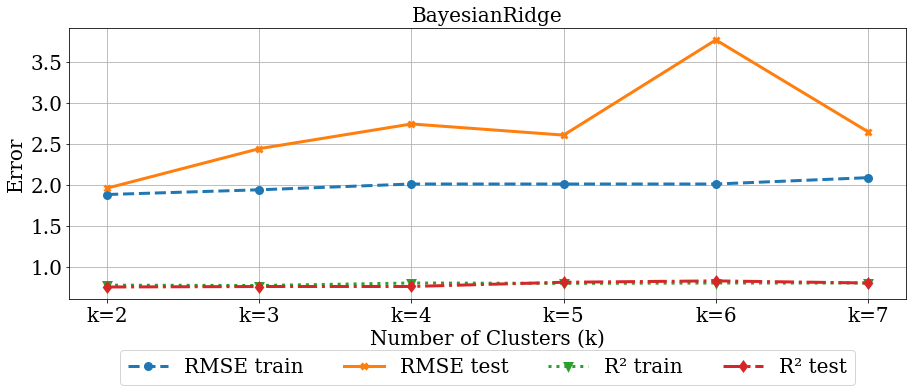

In [16]:
plot_error_scores(results['cluster_results_br'], 'BayesianRidge')

In [ ]:
errors = get_error_score(df, columns, Lasso())
model_errors['Lasso'] = errors

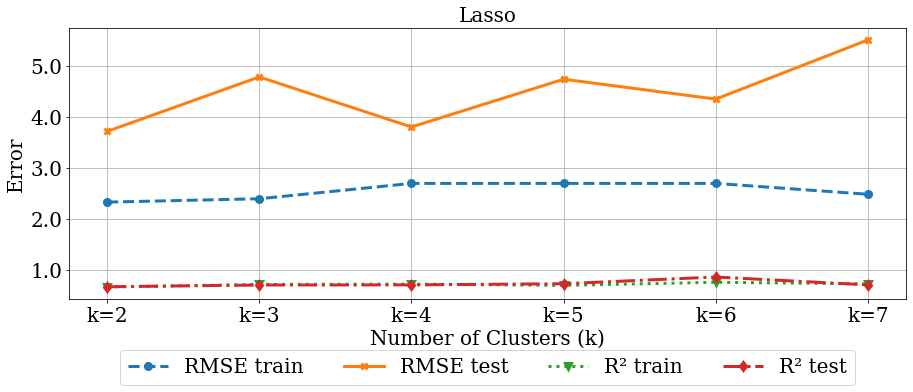

In [17]:
plot_error_scores(results['cluster_results_lasso'], 'Lasso')

In [ ]:
errors = get_error_score(df, columns, Ridge())
model_errors['Ridge'] = errors

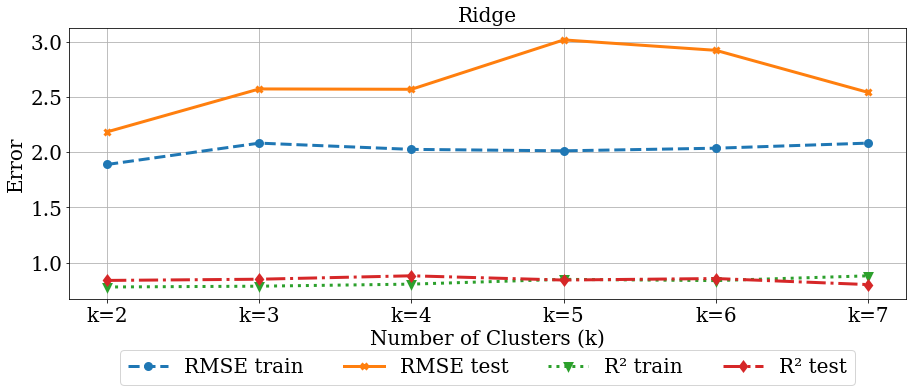

In [18]:
plot_error_scores(results['cluster_results_ridge'], 'Ridge')

In [ ]:
errors = get_error_score(df, columns, BaggingRegressor())
model_errors['BaggingRegressor'] = errors

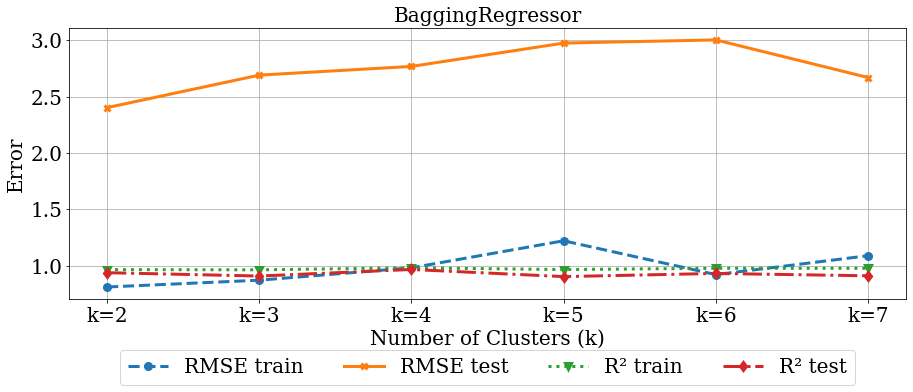

In [19]:
plot_error_scores(results['cluster_results_bagging_reg'], 'BaggingRegressor')

In [ ]:
errors = get_error_score(df, columns, AdaBoostRegressor())
model_errors['AdaBoostRegressor'] = errors

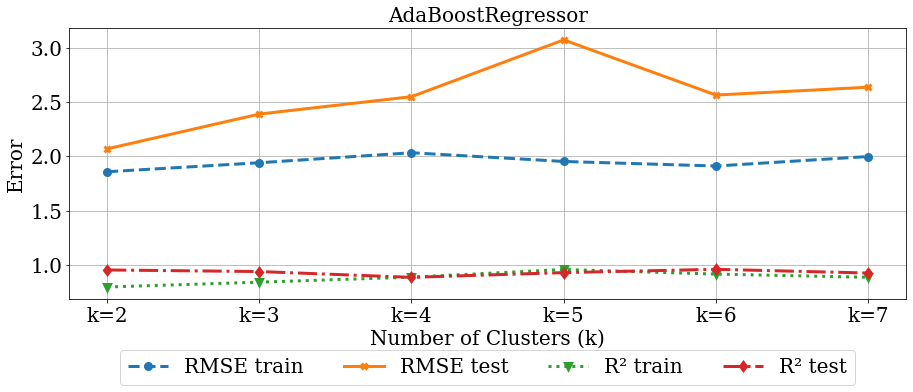

In [20]:
plot_error_scores(results['cluster_results_adaboost'], 'AdaBoostRegressor')

In [ ]:
errors = get_error_score(df, columns, RandomForestRegressor())
model_errors['RandomForestRegressor'] = errors

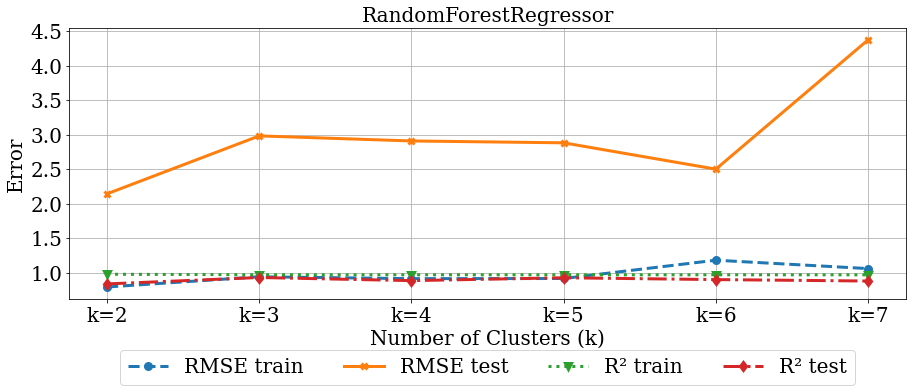

In [21]:
plot_error_scores(results['cluster_results_rf'], 'RandomForestRegressor')

In [ ]:
errors = get_error_score(df, columns, GradientBoostingRegressor())
model_errors['GradientBoostingRegressor'] = errors

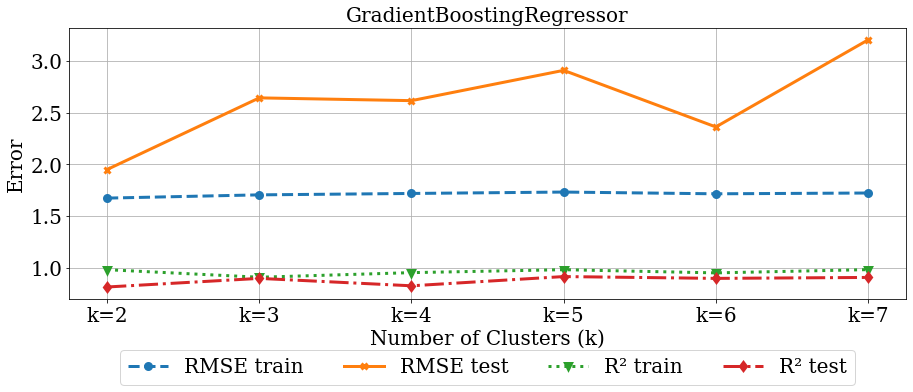

In [22]:
plot_error_scores(results['cluster_results_gbreg'], 'GradientBoostingRegressor')